### Aim
To build a model that classifies a comment as spam or not spam given You Tube comments

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
#import datetime as dt
from dateutil import parser
#import calendar as cl
import seaborn as sns


import sklearn.feature_extraction.text as sfe
import sklearn.naive_bayes

% matplotlib inline

In [2]:
path = r'YoutubeData/' # use your path
allFiles = glob.glob(path + "/*.csv")

frame = pd.DataFrame()

list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

In [3]:
frame['Index'] = range(0, len(frame))
frame = frame.set_index('Index')
New = frame.copy()
New = New.sample( frac =1, random_state = 5)      

New = New.iloc[np.random.permutation(len(New))]
New = New.reset_index()
del New['Index']

Follwowing is the module that performs KFold cross-validation to test for the average performance of the 'text' feature on classification of data :

In [4]:
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

In [5]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()
classifier = sklearn.naive_bayes.MultinomialNB()
scores = []
confusion = np.array([[0, 0], [0, 0]])

In [6]:
for train, test in KFold(5).split(New) :
    
    train_data = New.iloc[train]['CONTENT'].values
    test_data = New.iloc[test]['CONTENT'].values
    
    spam_in_train = (New.iloc[train]['CLASS'] == 1)
    spam_in_test = (New.iloc[test]['CLASS'] == 1)
    
    vectorizer = sfe.CountVectorizer(stop_words = 'english')
    
    train_matrix = vectorizer.fit_transform(train_data)
    test_matrix = vectorizer.transform(test_data)
    
    classifier = sklearn.naive_bayes.MultinomialNB()
    classifier.fit(train_matrix, spam_in_train)
    
    predicted_spam = classifier.predict(test_matrix)
#    predicted_probs = classifier.predict_proba(test_matrix)
    accuracy = classifier.score(test_matrix, spam_in_test)

#    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(spam_in_test, predicted_spam)
    
    confusion = confusion_matrix(spam_in_test, predicted_spam)
    print(len(spam_in_test), len(predicted_spam), "\n", confusion)
    score = f1_score(spam_in_test, predicted_spam)
    scores.append(score)
    
print('Total comments classified:', len(New))
print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

392 392 
 [[167  25]
 [ 12 188]]
391 391 
 [[165  22]
 [  9 195]]
391 391 
 [[172  22]
 [ 12 185]]
391 391 
 [[168  26]
 [ 13 184]]
391 391 
 [[156  28]
 [ 10 197]]
Total comments classified: 1956
Score: 0.913766588675
Confusion matrix:
[[156  28]
 [ 10 197]]


Average performance of module using language vectorizer is 91%

The CountVectorizer() enriches its vocabulary using the words in the comments, which means that it learns garbage like '#@$fINMSG' and some various URLS independently. 

URLs in comments could be used as a separate estimator to improve classification accuracy.

#### To check whether any new information can be gleaned from the Date-Time stamp on each comment.

In [7]:
DT = pd.DataFrame(New[New.DATE.notnull()])
DT = DT.reset_index(drop = True)
DT['new_col'] = DT.DATE.apply(lambda x : parser.parse(x))
DT['date'] = [d.date() for d in DT.new_col]
DT['time'] = [d.time() for d in DT.new_col]

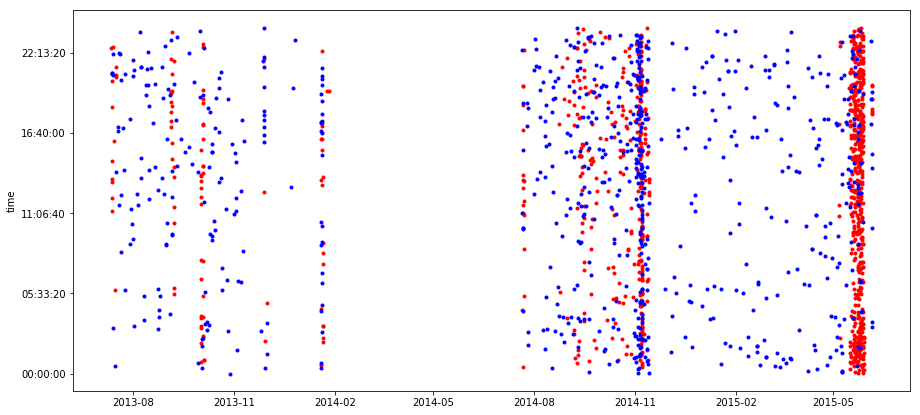

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
ax.plot(DT.date[DT.CLASS == 0], DT.time[DT.CLASS == 0], 'r.')
ax.plot(DT.date[DT.CLASS == 1], DT.time[DT.CLASS == 1], 'b.')
#plt.xlim('2015-05', '2015-07')                                    uncomment to zoom in on 2 months

As seen in the above, the spam comments (in blue) seem to be spread out over the dates, while the ham comments are concentrated usually over a period of around a two-weeks or less. However if you peek into the data set below, the close binning of ham comments is not due to any chain-reaction of replies to sparky comments. 

The data seems to have been chosen with some bias against replies, which implies that the Date-Time column is not a strong estimator for this data set.

In [18]:
New.sort_values('DATE')

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
1773,_2viQ_Qnc685RPw1aSa1tfrIuHXRvAQ2rPT9R06KTqA,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0
1409,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0
628,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0
1223,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
740,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0
1894,_2viQ_Qnc6_1Hq9MGlefkBIszt9rYD3S_CozADvMhQ4,Dinova Sharon,2013-07-13T14:44:00.700000,well done shakira,0
969,_2viQ_Qnc689m-WiwOwvrQU7LvkLAgspnfXL8ovE0ME,TheHotChocolate,2013-07-13T18:26:37.017000,she is sooooo beautiful!,0
206,_2viQ_Qnc68TufyXKiTwky80ewSPbhRiD5XFHrJH9lg,Ysobel Schofield,2013-07-13T20:17:25.181000,Waka waka she rules,0
763,_2viQ_Qnc6_RKHVetk9kLzx8ZC62_J7y73FWFSBTe8Q,ThirdDegr3e,2013-07-13T20:47:40.793000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
1713,_2viQ_Qnc69MEEHHJxZ427KX8MlljJPnUC2YBbvbWwY,ThirdDegr3e,2013-07-13T20:48:06.033000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
